In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split, Subset
import torch_optimizer as optim  # 提供 Ranger 优化器
from torch.amp import autocast, GradScaler

import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

from coordatt import CoordAtt

from sklearn.metrics import confusion_matrix
import seaborn as sns

from sklearn.metrics import accuracy_score, classification_report

In [3]:
# 超参数
batch_size = 128
lr = 1e-3
num_epochs = 20
model_name = 'resnet50'  # 可选：'simplecnn' 或 'resnet50'

# --- Setup MPS device ---
device = torch.device('mps') if torch.backends.mps.is_available() else torch.device('cpu')

In [4]:
class Bottleneck(nn.Module):
    expansion = 4
    def __init__(self, in_planes, planes, stride=1, downsample=None, ca_reduction=32):
        super().__init__()
        # 1×1 降维
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1   = nn.BatchNorm2d(planes)
        # 3×3 空洞感受野
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2   = nn.BatchNorm2d(planes)
        # 1×1 恢复维度
        self.conv3 = nn.Conv2d(planes, planes * self.expansion,
                               kernel_size=1, bias=False)
        self.bn3   = nn.BatchNorm2d(planes * self.expansion)

        # **CoordAtt 模块**
        self.ca    = CoordAtt(planes * self.expansion,
                              planes * self.expansion,
                              reduction=ca_reduction)
        # 如果跨步或通道数变化，用下采样调整捷径
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))


        # 在 addition 之前做 Coordinate Attention
        out = self.ca(out)

        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        return self.relu(out)

class SimpleResNetLike(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()

        # 初始层（可以改成 3×3 conv + BN + ReLU，去掉大核7×7）
        self.stem = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        )
        # 四个 stage，block 数量可按 ResNet-50 ([3,4,6,3]) 或简化
        self.layer1 = self.make_layer( 64,  64, blocks=3, stride=1)  # 输出 256 通道
        self.layer2 = self.make_layer(256, 128, blocks=4, stride=2)  # 输出 512 通道
        self.layer3 = self.make_layer(512, 256, blocks=6, stride=2)  # 输出1024 通道
        self.layer4 = self.make_layer(1024,512, blocks=3, stride=2)  # 输出2048 通道

        # 全局池化 + 全连接
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512 * Bottleneck.expansion, num_classes)

        self._init_weights()

    def make_layer(self, in_planes, planes, blocks, stride=1):
        downsample = None
        out_planes = planes * Bottleneck.expansion
        if stride != 1 or in_planes != out_planes:
            # 用 1×1 卷积来匹配维度 & 跨步下采样
            downsample = nn.Sequential(
                nn.Conv2d(in_planes, out_planes,
                        kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_planes),
            )
        layers = [Bottleneck(in_planes, planes, stride, downsample)]
        for _ in range(1, blocks):
            layers.append(Bottleneck(out_planes, planes))
        return nn.Sequential(*layers)

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                # He 初始化
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                # 全连接层也可以做类似初始化
                nn.init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='linear')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                # BN 的 weight 初始化为 1，bias 为 0
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        x = self.stem(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        return self.fc(x)

In [5]:
# 可选模型：SimpleCNN 或 ResNet50
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 32 * 32, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)


def get_model(name='resnet50', num_classes=10):
    if name.lower() == 'resnet50':
        model = torchvision.models.resnet50(pretrained=False)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    else:
        model = SimpleResNetLike(num_classes)
    return model







In [6]:
def train_epoch(model, device, loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    return running_loss / len(loader.dataset)


def evaluate(model, device, loader, criterion):
    model.eval()
    correct, total_loss = 0, 0.0
    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item() * inputs.size(0)
            _, preds = outputs.max(1)
            correct += preds.eq(targets).sum().item()
    return total_loss / len(loader.dataset), correct / len(loader.dataset)

In [7]:
def split_train_val_index(full_train, train_ratio=0.8):
    train_indices, val_indices = random_split(
        list(range(len(full_train))),
        [int(len(full_train) * train_ratio), len(full_train) - int(len(full_train) * train_ratio)]
    )
    return train_indices, val_indices

In [8]:
def get_data_augmentation(train_indices, val_indices):
    # 数据增强与标准化
    transform_train = transforms.Compose([
        transforms.Resize((128, 128), interpolation=transforms.InterpolationMode.BICUBIC),

        transforms.RandomCrop(128, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2430, 0.2610))
    ])
    transform_test = transforms.Compose([
        transforms.Resize((128, 128), interpolation=transforms.InterpolationMode.BICUBIC),

        
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2430, 0.2610))
    ])

    train_set = Subset(
        torchvision.datasets.CIFAR10(root='./data', train=True, download=False, transform=transform_train),
        train_indices.indices if hasattr(train_indices, 'indices') else train_indices
    )
    val_set = Subset(
        torchvision.datasets.CIFAR10(root='./data', train=True, download=False, transform=transform_test),
        val_indices.indices if hasattr(val_indices, 'indices') else val_indices
    )

    test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
    
    return train_set, val_set, test_set

In [9]:
# 加载训练集并拆分为 train/val
full_train = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)
train_indices, val_indices = split_train_val_index(full_train, train_ratio=0.8)

# get train/val/test sets after data pre-processing and augmentation
train_set, val_set, test_set = get_data_augmentation(train_indices, val_indices)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [10]:


# 模型、损失、优化器
model = get_model("SimpleResNetLike").to(device)

# Use ResNet50 as the model
num_classes = 10
# model = torchvision.models.resnet50(pretrained=False)
# model.fc = nn.Linear(model.fc.in_features, num_classes)

# model = SimpleCNN(num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Ranger(model.parameters(), lr=lr)
scaler = GradScaler()  # 用于混合精度训练

# get the information of the optimizer
print(optimizer)

# 训练与验证
train_losses, val_losses, val_accs = [], [], []

best_val_acc = 0.0
for epoch in range(num_epochs):
    train_loss = train_epoch(model, device, train_loader, criterion, optimizer)
    val_loss, val_acc = evaluate(model, device, val_loader, criterion)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    print(f"Epoch {epoch:02d} | Train Loss: {train_loss:.4f} | "
            f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc * 100:.2f}%")
    # 保存最优模型
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), './model/best_model_cnn_cifar.pth')





Ranger (
Parameter Group 0
    N_sma_threshhold: 5
    alpha: 0.5
    betas: (0.95, 0.999)
    eps: 1e-05
    k: 6
    lr: 0.001
    step_counter: 0
    weight_decay: 0
)


/opt/anaconda3/envs/mytorch/lib/python3.10/site-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/opt/anaconda3/envs/mytorch/lib/python3.10/site-packages/pytorch_ranger/ranger.py:172: UserWarning: This overload of addcmul_ is deprecated:
	addcmul_(Number value, Tensor tensor1, Tensor tensor2)
Consider using one of the following signatures instead:
	addcmul_(Tensor tensor1, Tensor tensor2, *, Number value = 1) (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/python_arg_parser.cpp:1581.)
  exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)


Epoch 00 | Train Loss: 1.5543 | Val Loss: 1.2321 | Val Acc: 55.43%
Epoch 01 | Train Loss: 1.0625 | Val Loss: 0.9842 | Val Acc: 65.09%
Epoch 02 | Train Loss: 0.8400 | Val Loss: 0.9040 | Val Acc: 67.78%
Epoch 03 | Train Loss: 0.6714 | Val Loss: 0.9023 | Val Acc: 69.38%
Epoch 04 | Train Loss: 0.5682 | Val Loss: 0.7704 | Val Acc: 74.48%
Epoch 05 | Train Loss: 0.4885 | Val Loss: 0.5498 | Val Acc: 81.07%
Epoch 06 | Train Loss: 0.4352 | Val Loss: 0.5369 | Val Acc: 81.96%
Epoch 07 | Train Loss: 0.3807 | Val Loss: 0.5875 | Val Acc: 80.72%
Epoch 08 | Train Loss: 0.3433 | Val Loss: 0.5443 | Val Acc: 82.11%
Epoch 09 | Train Loss: 0.3119 | Val Loss: 0.5624 | Val Acc: 81.60%
Epoch 10 | Train Loss: 0.2747 | Val Loss: 0.6474 | Val Acc: 80.33%
Epoch 11 | Train Loss: 0.2578 | Val Loss: 0.4526 | Val Acc: 85.52%
Epoch 12 | Train Loss: 0.2261 | Val Loss: 0.4840 | Val Acc: 84.70%
Epoch 13 | Train Loss: 0.2012 | Val Loss: 0.5003 | Val Acc: 84.81%
Epoch 14 | Train Loss: 0.1841 | Val Loss: 0.5084 | Val Acc: 84

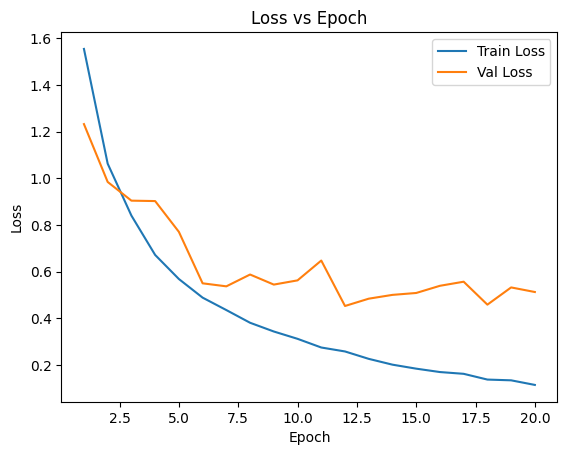

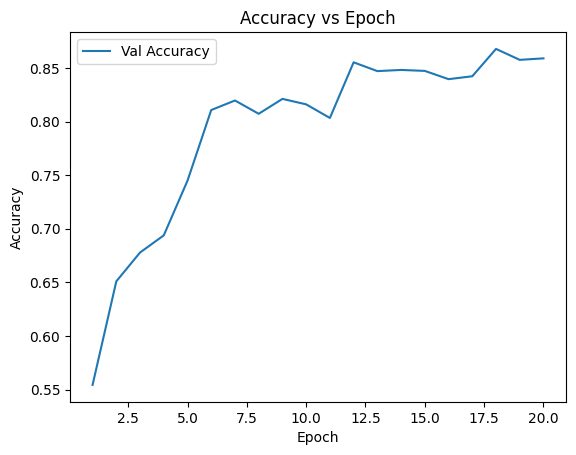

In [11]:
# Loss 曲线
plt.figure()
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses,   label='Val Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.legend(); plt.title('Loss vs Epoch')
plt.show()

# Accuracy 曲线
plt.figure()
plt.plot(range(1, num_epochs+1), val_accs, label='Val Accuracy')
plt.xlabel('Epoch'); plt.ylabel('Accuracy')
plt.legend(); plt.title('Accuracy vs Epoch')
plt.show()

In [12]:
# 测试集评估
model.load_state_dict(torch.load('./model/best_model_cnn_cifar.pth'))
test_loss, test_acc = evaluate(model, device, test_loader, criterion)
print(f"\nFinal Test Loss: {test_loss:.4f} | Final Test Acc: {test_acc * 100:.2f}%")

/var/folders/y0/5zx_gdxj5rvb7c3v91ml3v780000gn/T/ipykernel_14940/1345411143.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./model/bes


Final Test Loss: 0.4850 | Final Test Acc: 86.22%


In [ ]:
def get_preds_and_targets(model, device, loader):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, preds = outputs.max(1)
            y_true.extend(targets.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            
    return np.array(y_true), np.array(y_pred)

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=True,
                          title="Confusion matrix",
                          cmap=plt.cm.Blues):
    # 1. 计算 raw CM 并归一化
    cm = confusion_matrix(y_true, y_pred, labels=range(len(classes)))
    if normalize:
        cm = cm.astype(float) / cm.sum(axis=1)[:, np.newaxis]

    # 2. 画图
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt=".2f" if normalize else "d",
                cmap=cmap,
                xticklabels=classes,
                yticklabels=classes)
    plt.ylabel('True')
    plt.xlabel('Predicted')
    plt.title(title)
    plt.tight_layout()
    plt.show()

# 假设 test_loaders 是一个 dict，比如 {'testA': loaderA, 'testB': loaderB}
model.load_state_dict(torch.load('./model/best_model_cnn_icubr.pth'))
# for name, loader in test_loaders.items():
# 取出所有真实 & 预测标签
y_true, y_pred = get_preds_and_targets(model, device, test_loader)
# 拿到 class 名称列表
# 如果 loader.dataset 是 Subset，就取 subset.dataset.classes
ds = test_loader.dataset
if hasattr(ds, 'dataset'):  # Subset
    classes = ds.dataset.classes
else:
    classes = ds.classes

report = classification_report(
            y_true,
            y_pred,
            target_names=classes,
            digits=4   # 控制小数点后几位
        )
print(f"\n=== Classification Report on Test Set ===")
print(report)

# 画图
plot_confusion_matrix(
    y_true, y_pred, classes,
    normalize=True,
    title=f"Test Set Confusion Matrix"
)